# Titanic
Work on the [Titanic](https://www.kaggle.com/c/titanic) kaggle competition.

## Useful info
[link](https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9) to some good explanation about data preprocessing.

## Overall idea
Build several logistic regression modelto classify people based on their features. I'll start from a very basic one, i.e. logistic regression with just the available features and add more complexity step by step on both feature handling (e.g. feature normalisation, etc.) and the model itself (e.g. more features, more complex models).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import utils
import socket
import operator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

%matplotlib inline

## Load the data
Load the data and do some very preliminary exploration.

In [2]:
data_path = utils.getDataPath()

In [3]:
df_train = pd.read_csv('{}/train.csv'.format(data_path), skipinitialspace=True)

In [4]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

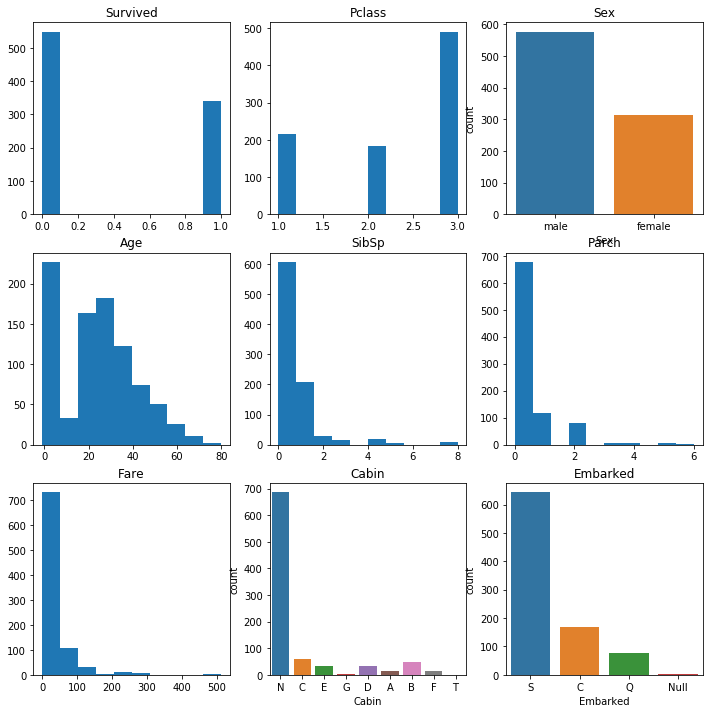

In [6]:
# plot all "plottable" variables
vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        idx = 3*i + j
        var = vars[idx]
        axes[i,j].set_title(var)
        if is_string_dtype(df_train[var]):
            df_tmp = df_train[var].fillna('Null')
            if var == 'Cabin':
                df_tmp = df_train[var].fillna('Null').str[0]
            sb.countplot(x=df_tmp, ax=axes[i,j])
        else:
            df_tmp = df_train[var].fillna(-1)
            _ = axes[i,j].hist(df_tmp)
        

### Comments on raw vars
`Age` can be `null`, and this happens ha sizeable amount of times (177 times out of 891). At a first look this doesn't seem to be (strongly) correlated to any of the other features.

Third class (`Pclass` = 3) people are not assigned any cabin (`Cabin` = Nan).

### Relations between variables
Try to study the relations between some variables.

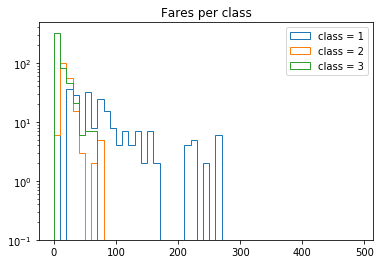

In [7]:
plt.figure()
plt.title('Fares per class')
for c in np.sort(df_train.Pclass.unique()):
    _ = plt.hist(df_train[ df_train.Pclass==c ].Fare, bins=range(0,500,10), histtype='step', label='class = {}'.format(c), log=True)
plt.legend(loc='best')

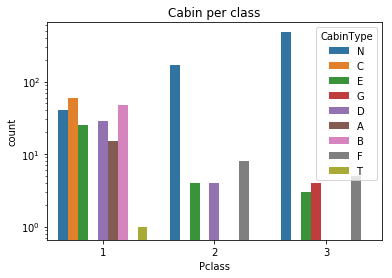

In [8]:
df_tmp = df_train.assign(CabinType = lambda x : x.Cabin.fillna('Null').str[0])

plt.figure()
plt.title('Cabin per class')
sb.countplot(x='Pclass', data=df_tmp, hue='CabinType', log=True)

What is written above is not entirely true: cabins are available for all classes, but they have some kind of distribution. The majority of 3rd class people do not have a cabin, but also some second and first class people do not have a cabin. G cabins seem to be reseved to 3rd class people, while some other types are reserved to second and first class people. The only kind of cabins available for all the three classes are E cabins.

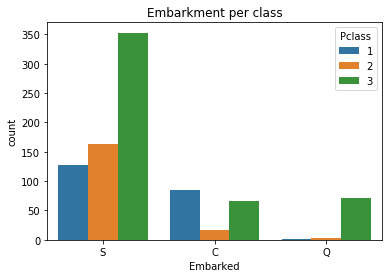

In [9]:
plt.figure()
plt.title('Embarkment per class')
sb.countplot(x='Embarked', data=df_train, hue='Pclass', log=False)

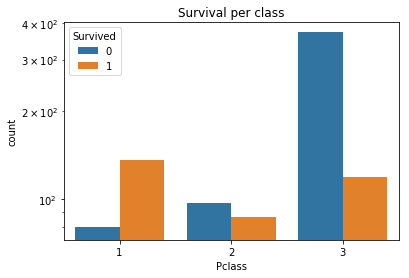

In [10]:
plt.figure()
plt.title('Survival per class')
sb.countplot(x='Pclass', data=df_train, hue='Survived', log=True)

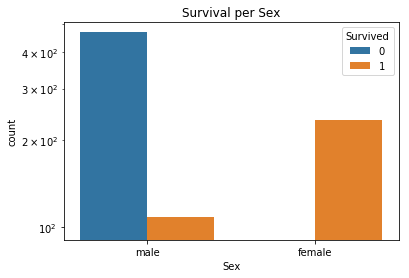

In [11]:
plt.figure()
plt.title('Survival per Sex')
sb.countplot(x='Sex', data=df_train, hue='Survived', log=True)

## Playing with the models
In this section the models are built and fitted.  
The original training set is split in actual training and validation set in order to be able to compare performances.

### v00: minimal engineering
In this version I just use the input features as they are. Neverthelsess some data preprocessing is anyway needed:
* replace `NaN`s with a fixed value
* replace `str` value with numeric values (doing the most basic thing)

In [12]:
def prepareData_00(df_in, cleanNaNs=True):
    
    df = df_in.copy()
    
    feat_list = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
    input_feat_list = feat_list.copy()
    
    #############################################
    # take care of categorical features
    #############################################
    
    # sex: male = 0 / female = 1
    df = df.assign(Sex_cat = 0)
    df.loc[ df['Sex']=='female', 'Sex_cat' ] = 1
    input_feat_list = utils.replaceElementInList('Sex', 'Sex_cat', input_feat_list)
    
    # cabin: take the first char, then map to ints
    cabin_to_int_dict = {}
    idx = 0
    for entry in df.Cabin.fillna('Null').str[0].unique():
        cabin_to_int_dict[entry] = idx
        idx += 1
    df = df.assign(Cabin_cat = lambda x : x.Cabin.fillna('Null').str[0].map(cabin_to_int_dict))
    input_feat_list = utils.replaceElementInList('Cabin', 'Cabin_cat', input_feat_list)
    
    # embarked: map to ints
    embarked_to_int_dict = {}
    idx = 0
    for entry in df.Embarked.fillna('Null').unique():
        embarked_to_int_dict[entry] = idx
        idx += 1
    df = df.assign(Embarked_cat = lambda x : x.Embarked.fillna('Null').map(embarked_to_int_dict))
    input_feat_list = utils.replaceElementInList('Embarked', 'Embarked_cat', input_feat_list)
    
    # replace NaNs with -1
    if cleanNaNs:
        for c in df.columns:
            if not is_string_dtype(df[c]):
                df[c] = df[c].fillna(-1)
    
    return df, input_feat_list

In [13]:
df00, m00_input_feat_list = prepareData_00(df_train)

In [14]:
df00.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Cabin_cat,Embarked_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0


In [15]:
# split the features from the target
x00 = df00[m00_input_feat_list].values
y00 = df00['Survived'].values

In [16]:
x00.shape

(891, 8)

In [17]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x00_train, x00_val, y00_train, y00_val = train_test_split(x00, y00, test_size=.15)

In [18]:
x00_val.shape

(134, 8)

Now build the model.

In [19]:
m00 = LogisticRegression()

In [20]:
res00 = m00.fit(x00_train, y00_train)

/Users/francesco/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
y00_train_score = m00.decision_function(x00_train)
y00_val_score = m00.decision_function(x00_val)

In [22]:
#y00_val_pred

In [23]:
p00, e00 = utils.getFullParameters(res00, x00_train)

#### Insights
Here let's see some model insights.

Let's rank the features according to their t-statistic.

In [24]:
# since the utils.getFullParameters(..) function returns values including the intercept, let's add it to the features
m00_final_feat_list = m00_input_feat_list.copy()
m00_final_feat_list.insert(0, 'Intercept')

In [25]:
d00 = {}
for idx in range( len(m00_final_feat_list) ):
    #print(m00_input_feat_list[idx])
    #print(abs((p00 / e00)[idx]))
    d00[ m00_final_feat_list[idx] ] = abs((p00 / e00)[idx])

In [26]:
d00_sorted = sorted(d00.items(), key=operator.itemgetter(1), reverse=True)

In [27]:
d00_sorted

[('Sex_cat', 12.481916512010873),
 ('Pclass', 4.223868812534556),
 ('Cabin_cat', 2.676101586055872),
 ('SibSp', 2.4877580396437606),
 ('Age', 2.455835874263739),
 ('Fare', 1.6254478333428297),
 ('Parch', 0.8770509038054866),
 ('Embarked_cat', 0.6893377265264417),
 ('Intercept', 0.6206117384173674)]

### v01: proper mapping
`v01` will be exactly the same as `v00` in terms of which features are used, but as a first step forward the handling of categorical features will be done better, using the tools provided by `sklern`.

In [28]:
def prepareData_01(df_in, ext_feat_list=None):
    
    df = df_in.copy()
    
    # interesting features (discarding 'Ticket' for now)
    feat_list = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
    input_feat_list = feat_list.copy()
    
    #############################################
    # take care of categorical features
    #############################################
    
    # age
    df.Age.fillna( df.Age.mean(), inplace=True )
    
    # cabin: take the first char
    df = df.assign(Cabin_cat = lambda x : x.Cabin.fillna('Null').str[0])
    input_feat_list = utils.replaceElementInList('Cabin', 'Cabin_cat', input_feat_list)
    
    # embarked
    df.Embarked.fillna('Null', inplace=True)
    
    # one-hot encoding
    onehot = OneHotEncoder(dtype=np.int, sparse=True)
    nominals = pd.DataFrame( onehot.fit_transform(df[ ['Sex', 'Cabin_cat', 'Embarked'] ]).toarray(), columns=pd.get_dummies(df[ ['Sex', 'Cabin_cat', 'Embarked'] ]).columns.tolist() )
    
    # join the one-hot encoded feats
    df = df.join(nominals)
    
    # update the input list
    # - remove the old categories
    for entry in ['Sex', 'Cabin_cat', 'Embarked']:
        if not entry in input_feat_list: continue
        input_feat_list.remove(entry)
    # - add the new ones
    for entry in nominals.columns.tolist():
        if entry in input_feat_list: continue
        input_feat_list.append(entry)
    
    if ext_feat_list:
        for entry in ext_feat_list:
            if entry not in input_feat_list:
                df = df.assign(entry = 0)
                df = df.rename(index=str, columns={'entry' : entry})
                input_feat_list.append(entry)
    
    return df, input_feat_list

In [29]:
df01, m01_input_feat_list = prepareData_01(df_train)

In [30]:
m01_input_feat_list

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Cabin_cat_A',
 'Cabin_cat_B',
 'Cabin_cat_C',
 'Cabin_cat_D',
 'Cabin_cat_E',
 'Cabin_cat_F',
 'Cabin_cat_G',
 'Cabin_cat_N',
 'Cabin_cat_T',
 'Embarked_C',
 'Embarked_Null',
 'Embarked_Q',
 'Embarked_S']

Now prepare the actual datasets

In [31]:
x01 = df01[m01_input_feat_list].values
y01 = df01['Survived'].values

In [32]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x01_train, x01_val, y01_train, y01_val = train_test_split(x01, y01, test_size=.15)

In [33]:
x01_train.shape

(757, 20)

Now build the model

In [34]:
m01 = LogisticRegression(verbose=1)

In [35]:
res01 = m01.fit(x01_train, y01_train)

[LibLinear]

/Users/francesco/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
y01_train_score = m01.decision_function(x01_train)
y01_val_score = m01.decision_function(x01_val)

In [37]:
p01, e01 = utils.getFullParameters(res01, x01_train)

/Users/francesco/PersonalProjects/kaggle-titanic/utils.py:46: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


In [38]:
# debug
probs = res01.predict_proba(x01_train)
x = np.hstack([np.ones((x01_train.shape[0], 1)), x01_train])
V = np.diagflat(np.product(probs, axis=1))
cov = np.linalg.inv(np.dot(np.dot(x.T, V), x))

In [39]:
np.diag(cov)

array([-3.90869395e+12,  3.79674384e-02,  7.44649171e-05,  1.47629269e-02,
        1.66851963e-02,  1.10947484e-05,  1.32678040e+13,  1.30145545e+13,
       -8.60011938e+12, -8.60011938e+12, -8.60011938e+12, -8.60011938e+12,
       -8.60011938e+12, -8.60011938e+12, -8.60011938e+12, -8.60011938e+12,
       -8.60011938e+12,  7.05158749e+13,  7.05158749e+13,  7.05158749e+13,
        7.05158749e+13])

#### Insigths

In [40]:
# since the utils.getFullParameters(..) function returns values including the intercept, let's add it to the features
m01_final_feat_list = m01_input_feat_list.copy()
m01_final_feat_list.insert(0, 'Intercept')

In [41]:
d01 = {}
for idx in range( len(m01_final_feat_list) ):
    #print(m00_input_feat_list[idx])
    #print(abs((p00 / e00)[idx]))
    d01[ m01_final_feat_list[idx] ] = abs((p01 / e01)[idx])

In [42]:
d01_sorted = sorted(d01.items(), key=operator.itemgetter(1), reverse=True)

In [43]:
d01_sorted

[('Intercept', nan),
 ('Age', 4.382708340760885),
 ('Pclass', 4.16431346255925),
 ('SibSp', 2.9907855095647276),
 ('Fare', 1.1601349369292253),
 ('Parch', 1.0057188453900967),
 ('Sex_female', 6.179146369733646e-07),
 ('Sex_male', 1.3781012053924698e-07),
 ('Cabin_cat_A', nan),
 ('Cabin_cat_B', nan),
 ('Cabin_cat_C', nan),
 ('Cabin_cat_D', nan),
 ('Cabin_cat_E', nan),
 ('Cabin_cat_F', nan),
 ('Cabin_cat_G', nan),
 ('Cabin_cat_N', nan),
 ('Cabin_cat_T', nan),
 ('Embarked_C', 9.962922243126188e-08),
 ('Embarked_Q', 4.86859675131875e-08),
 ('Embarked_S', 3.6474988971319134e-08),
 ('Embarked_Null', 2.403635900548158e-08)]

### v02: minimal engineering + feature scaling
Let's go back to something simple as `m00`, but let's use feature scaling.

In [44]:
def prepareData_02(df_in):
    
    # get the same data format as 00
    df, input_feat_list = prepareData_00(df_in, cleanNaNs=False)
    
    # clean NaNs in Age
    df.Age.fillna( np.mean(df.Age), inplace=True )
    
    # scale features
    scaler = StandardScaler()
    xxx = scaler.fit_transform(df[ input_feat_list ].values)
    df.loc[:, input_feat_list] = xxx
    
    return df, input_feat_list

In [45]:
df02, m02_input_feat_list = prepareData_02(df_train)

In [46]:
x02 = df02[ m02_input_feat_list ].values
y02 = df02['Survived'].values

In [47]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x02_train, x02_val, y02_train, y02_val = train_test_split(x02, y02, test_size=.15)

In [48]:
x02_train.shape

(757, 8)

In [49]:
m02 = LogisticRegression(verbose=1)

In [50]:
res02 = m02.fit(x02_train, y02_train)

[LibLinear]

/Users/francesco/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
y02_train_score = m02.decision_function(x02_train)
y02_val_score = m02.decision_function(x02_val)

In [52]:
p02, e02 = utils.getFullParameters(res02, x02_train)

#### Insights

In [53]:
# since the utils.getFullParameters(..) function returns values including the intercept, let's add it to the features
m02_final_feat_list = m02_input_feat_list.copy()
m02_final_feat_list.insert(0, 'Intercept')

In [54]:
d02 = {}
for idx in range( len(m02_final_feat_list) ):
    d02[ m02_final_feat_list[idx] ] = abs((p02 / e02)[idx])

In [55]:
d02_sorted = sorted(d02.items(), key=operator.itemgetter(1), reverse=True)

In [56]:
d02_sorted

[('Sex_cat', 12.102061204175659),
 ('Intercept', 6.654509844804549),
 ('Pclass', 5.930935346756731),
 ('Age', 4.701196387265491),
 ('SibSp', 2.1999425640166077),
 ('Cabin_cat', 2.085679260221033),
 ('Parch', 1.2828548258129853),
 ('Embarked_cat', 1.2347709058546361),
 ('Fare', 0.9378129293316523)]

### v03: decision tree
Same features as `m00` but now let's feed them to a Descision Tree.

In [57]:
df03, m03_input_feat_list = prepareData_00(df_train)

In [58]:
x03 = df03[m03_input_feat_list].values
y03 = df03['Survived'].values

In [59]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x03_train, x03_val, y03_train, y03_val = train_test_split(x03, y03, test_size=.15)

In [110]:
# hyper-parameters are sligthly optimised by iterations
m03 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
m03.fit(x03_train, y03_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [111]:
y03_train_pred = m03.predict(x03_train)
y03_val_pred = m03.predict(x03_val)

In [112]:
for idx in range(len(m03_input_feat_list)):
    print(m03_input_feat_list[idx], m03.feature_importances_[idx])

Pclass 0.1554124083761176
Sex_cat 0.5688690358712195
Age 0.06266407897688162
SibSp 0.016393609125534017
Parch 0.0
Fare 0.10936069697889729
Cabin_cat 0.07763663464035901
Embarked_cat 0.00966353603099088


In [113]:
print("Accuracy:", accuracy_score(y03_val, y03_val_pred))

Accuracy: 0.7835820895522388


## Evaluation and comparison

In [114]:
# model 00
fpr_00v, tpr_00v, thr_00v = roc_curve(y00_val, y00_val_score)
fpr_00t, tpr_00t, thr_00t = roc_curve(y00_train, y00_train_score)
roc_score_00 = roc_auc_score(y00_val, y00_val_score)

In [115]:
# model 01
fpr_01v, tpr_01v, thr_01v = roc_curve(y01_val, y01_val_score)
fpr_01t, tpr_01t, thr_01t = roc_curve(y01_train, y01_train_score)
roc_score_01 = roc_auc_score(y01_val, y01_val_score)

In [116]:
# model 02
fpr_02v, tpr_02v, thr_02v = roc_curve(y02_val, y02_val_score)
fpr_02t, tpr_02t, thr_02t = roc_curve(y02_train, y02_train_score)
roc_score_02 = roc_auc_score(y02_val, y02_val_score)

In [117]:
# model 03
tn03v, fp03v, fn03v, tp03v = confusion_matrix(y03_val, y03_val_pred).ravel()
fpr_03v = fp03v / float(fp03v + tn03v)
tpr_03v = tp03v / float(fn03v + tp03v)
acc_03 = accuracy_score(y03_val, y03_val_pred)

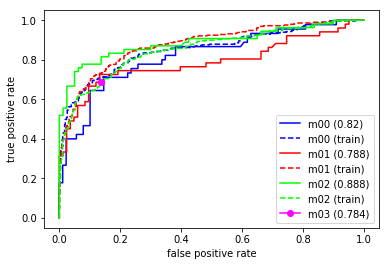

In [118]:
plt.figure()

plt.plot(fpr_00v, tpr_00v, color='b', label='m00 ({:.3})'.format(roc_score_00))
plt.plot(fpr_00t, tpr_00t, color='b', linestyle='--', label='m00 (train)')

plt.plot(fpr_01v, tpr_01v, color='r', label='m01 ({:.3})'.format(roc_score_01))
plt.plot(fpr_01t, tpr_01t, color='r', linestyle='--', label='m01 (train)')

plt.plot(fpr_02v, tpr_02v, color='lime', label='m02 ({:.3})'.format(roc_score_02))
plt.plot(fpr_02t, tpr_02t, color='lime', linestyle='--', label='m02 (train)')

plt.plot([fpr_03v,fpr_03v], [tpr_03v,tpr_03v], marker='o', color='magenta', label='m03 ({:.3})'.format(acc_03))
#point.plot(x='x', y='y', ax=ax, style='bx', label='point')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')

### Notes
`m00` and `m01` seem to be rather unstable since when the fit is rerun, the results change in every aspect:
- the value of the ROC score changes
- the relative position and the distance between the performance on the training and validation sets (i.e. the dashed and the continuous lines)
- the relative performances (e.g. `m00` is sometimes better than `m01`, while sometimes the viceversa is true)

To me this is an hint that the minimisation has not gone well, either there are local minima (is it even possible in Logistic Regression?) or the actual minimum is not reached by the time the result is returned.  

In particular `m01` is very unstable and the fit has strange behaviour resulting in a bad the covariance matrix (e.g. negative values on the diagonal) or a non-converging fit (!!!).

## Make the prediction(s)
Here get the final prediction for all the models.

In [119]:
def buildPredictionDF(df, pred):
    return pd.DataFrame.from_dict( {'PassengerId' : df.PassengerId.tolist(), 'Survived' : pred} )

In [120]:
df_test = pd.read_csv('{}/test.csv'.format(data_path), skipinitialspace=True)

In [121]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [122]:
for col in df_test.columns:
    if df_test[df_test[col].isna()].shape[0] > 0:
        print(col)

Age
Fare
Cabin


`Age` and `Cabin` are already taken care of, we need to explicitly fix the `NaN`s in `Fare`.

In [123]:
# can be refined based on the Pclass
df_test.Fare.fillna( np.mean(df_test.Fare), inplace=True )

In [124]:
df, input_list = prepareData_00(df_test)
y00_test_pred = m00.predict( df[input_list].values )
df00_pred = buildPredictionDF(df_test, y00_test_pred)

df00_pred.to_csv('{}/pred_00.csv'.format(data_path), index=False)

In [125]:
df, input_list = prepareData_01(df_test, ext_feat_list=m01_input_feat_list)
y01_test_pred = m01.predict( df[input_list].values )
df01_pred = buildPredictionDF(df_test, y01_test_pred)

df01_pred.to_csv('{}/pred_01.csv'.format(data_path), index=False)

In [126]:
df, input_list = prepareData_02(df_test)
y02_test_pred = m02.predict( df[input_list].values )
df02_pred = buildPredictionDF(df_test, y02_test_pred)

df02_pred.to_csv('{}/pred_02.csv'.format(data_path), index=False)

In [127]:
df, input_list = prepareData_00(df_test)
y03_test_pred = m03.predict( df[input_list].values )
df03_pred = buildPredictionDF(df_test, y03_test_pred)

df03_pred.to_csv('{}/pred_03.csv'.format(data_path), index=False)

## Post-submission summary
- `m00` and `m01` have exactly the same score (.75119) on the test set
- `m02` has slightly higher score (.75598)
- `m03` scores .74641